In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

In [2]:
transformation=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,),(0.3081,))])

train_dataset=datasets.MNIST('data/',train=True,transform=transformation,download=True)
test_dataset=datasets.MNIST('data/',train=False,transform=transformation,download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/home/dsp12357/venv_torch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
def plot_img(image):
    image=image.numpy()[0]
    mean=0.1307
    std=0.3081
    image=((mean*image)+std)
    plt.imshow(image,cmap='gray')

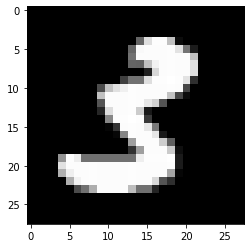

In [41]:
sample_data=next(iter(test_loader))
plot_img(sample_data[0][1])
plot_img(sample_data[0][2])

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,10,kernel_size=5)
        self.conv2=nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop=nn.Dropout2d()
        self.fc1=nn.Linear(320,50)
        self.fc2=nn.Linear(50,10)
        
    def forward(self,x):
        x=F.relu(F.max_pool2d(self.conv1(x),2))
        x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x=x.view(-1,320)
        x=F.relu(self.fc1(x))
        x=F.dropout(x,training=self.training)
        x=self.fc2(x)
        return F.log_softmax(x)

In [30]:
conv=nn.Conv1d(1,1,3,bias=False)
sample=torch.randn(1,1,7)
conv(Variable(sample))

conv.weight #필터 가중치 확인

Parameter containing:
tensor([[[-0.5513,  0.5152, -0.4857]]], requires_grad=True)

In [43]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase=='training':
        model.train()
    if phase=='validation':
        model.eval()
        volatile=True
        
    running_loss=0.0
    running_correct=0
    for batch_idx,(data,target) in enumerate(data_loader):
        if is_cuda:
            data,target=data.cuda(),target.cuda()
        data,target=Variable(data,volatile),Variable(target)
        if phase=='training':
            optimizer.zero_grad()
        output=model(data)
        loss=F.nll_loss(output,target)
        
        running_loss+=F.nll_loss(output,target,size_average=False).data
        preds=output.data.max(dim=1,keepdim=True)[1]
        running_correct+=preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase=='training':
            loss.backward()
            optimizer.step()
    loss=running_loss/len(data_loader.dataset)
    accuracy=100.*running_correct/len(data_loader.dataset)
            
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)} {accuracy:{10}.{4}}')
    return loss,accuracy

In [44]:
model=Net()
if is_cuda:
    model.cuda()
    
    
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.5)
train_losses,train_accuracy=[],[]
val_losses,val_accuracy=[],[]
for epoch in range(1,20):
    epoch_loss,epoch_accuracy=fit(epoch,model,train_loader,phase='training')
    val_epoch_loss,val_epoch_accuracy=fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    

/home/dsp12357/venv_torch/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


training loss is  0.72 and training accuracy is 45861/60000      76.43
validation loss is  0.14 and validation accuracy is 9604/10000      96.04
training loss is  0.31 and training accuracy is 54413/60000      90.69
validation loss is 0.092 and validation accuracy is 9694/10000      96.94
training loss is  0.25 and training accuracy is 55676/60000      92.79
validation loss is 0.076 and validation accuracy is 9763/10000      97.63
training loss is  0.22 and training accuracy is 56131/60000      93.55
validation loss is 0.062 and validation accuracy is 9787/10000      97.87
training loss is   0.2 and training accuracy is 56608/60000      94.35
validation loss is 0.051 and validation accuracy is 9831/10000      98.31
training loss is  0.18 and training accuracy is 56884/60000      94.81
validation loss is 0.052 and validation accuracy is 9817/10000      98.17
training loss is  0.17 and training accuracy is 57019/60000      95.03
validation loss is 0.049 and validation accuracy is 9853/10

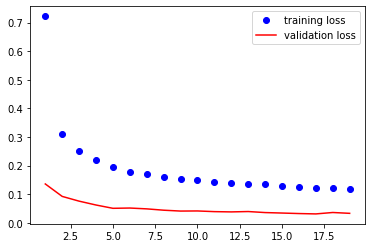

In [46]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

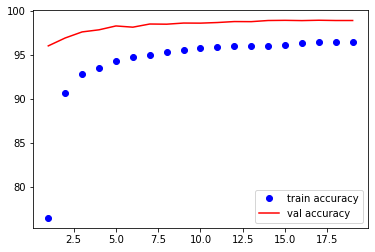

In [47]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()